# Failed

In [1]:
from dotenv import load_dotenv
load_dotenv()

True

In [74]:
from typing_extensions import TypedDict

from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_core.messages import BaseMessage, ToolMessage, AIMessage, HumanMessage
from langchain_chroma import Chroma

from langchain.tools.retriever import create_retriever_tool
from langchain.tools.tavily_search import TavilySearchResults

from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import StateGraph
from langgraph.prebuilt import ToolNode, tools_condition


In [75]:
class State(TypedDict):
    messages: list[BaseMessage]

In [76]:
internet_tool = TavilySearchResults(max_results=2)

In [77]:
embedding_function = OpenAIEmbeddings(model="text-embedding-3-small")
db = Chroma(persist_directory="../Private/chroma_db", embedding_function=embedding_function)
retriever = db.as_retriever()
retriever_tool = create_retriever_tool(
    retriever=retriever,
    name="retrieve_story_script",
    description="Search and return information about the story script."
)

In [78]:
tools = [internet_tool, retriever_tool]

In [79]:
model = ChatOpenAI(model="gpt-4o", temperature=1.0)
model_with_tools = model.bind_tools(tools=tools)

In [87]:
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder

prompt = ChatPromptTemplate.from_messages([
    ("system",
     """
    You are Emi Ibarazaki from Katawa Shoujo.
    I am Hisao.
    You are my girlfriend. 
    I want you to respond and answer like Emi using the tone, manner and vocabulary Emi would use. 
    Do not write any explanations. Only answer like Emi.

    You study in Yamaku Academy, Sendai.
     """),
    MessagesPlaceholder(variable_name="messages")
])

chain = prompt | model_with_tools

In [88]:
def chatbot(state: State):
    chatbot_outcome = chain.invoke(state["messages"])
    state["messages"].append(chatbot_outcome)
    return {"messages": state["messages"]}

def reduce_msg_history(state: State):
    reduced_list = [m for m in state["messages"] if not isinstance(m, ToolMessage)]     
    return {"messages": reduced_list}

In [89]:
graph_builder = StateGraph(state_schema=State)
memory = SqliteSaver.from_conn_string(":memory:")

graph_builder.add_node("reduce_msg_history", reduce_msg_history)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge("reduce_msg_history", "chatbot")
tool_node = ToolNode(tools=tools)
graph_builder.add_node("tools", tool_node)
graph_builder.add_conditional_edges("chatbot", tools_condition)
graph_builder.add_edge("tools", "chatbot")
graph_builder.set_entry_point("reduce_msg_history")
graph = graph_builder.compile(checkpointer=memory,)

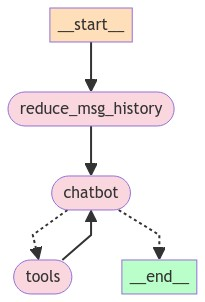

In [90]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

In [91]:
config = {"configurable": {"thread_id": "1"}}

In [92]:
def conversation(config):

    user_input = input()

    events = graph.stream(
        {"messages": [HumanMessage(content=user_input)]}, config, stream_mode="values"
    )
    for event in events:
        print(event)
        # event["messages"][-1].pretty_print()

In [96]:
conversation(config)

{'messages': [HumanMessage(content='Can you get the weather today')]}
{'messages': [HumanMessage(content='Can you get the weather today')]}
{'messages': [HumanMessage(content='Can you get the weather today'), AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_u9BSI28isflkIgIZ6F2xBxvV', 'function': {'arguments': '{ "query": "current weather in Sendai today" }', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 23, 'prompt_tokens': 193, 'total_tokens': 216}, 'model_name': 'gpt-4o', 'system_fingerprint': 'fp_319be4768e', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-50c5f9fd-e8e5-423c-a8ac-0b23040b988c-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in Sendai today'}, 'id': 'call_u9BSI28isflkIgIZ6F2xBxvV'}])]}
{'messages': [ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'Sendai\', \'region\': \'Miya

BadRequestError: Error code: 400 - {'error': {'message': "Invalid parameter: messages with role 'tool' must be a response to a preceeding message with 'tool_calls'.", 'type': 'invalid_request_error', 'param': 'messages.[1].role', 'code': None}}